<a href="https://colab.research.google.com/github/danielnrocha/HackathonAgroSenar/blob/main/Previs%C3%A3o_de_Temperatura_do_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Temperatura do Rio Grande do Sul
## Union Squad
Todos os dados utilizados foram consultado no CPTEC-INPE

In [1]:
%%capture
%pip install geopandas
%pip install unidecode
%pip install jupyterthemes 
%pip install xmltodict
%pip install plotly==4.14.0

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color','axes.titlesize',
    'figure.figsize','legend.framealpha'],['white','white','white','white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

In [5]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-43-mun.json') as response:
    regions = json.load(response)

In [6]:
import geopandas as gpd
import unidecode
geo = gpd.GeoDataFrame.from_features(regions["features"]).drop(columns='description')
geo.name = [unidecode.unidecode(i).lower() for i in geo.name]
geo.head()

,geometry,id,name
0,"POLYGON ((-54.11276 -31.42931, -54.09821 -31.4...",4300034,acegua
1,"POLYGON ((-52.04263 -28.11703, -52.03489 -28.1...",4300059,agua santa
2,"POLYGON ((-53.25560 -29.44736, -53.23478 -29.4...",4300109,agudo
3,"POLYGON ((-53.78588 -28.11270, -53.78654 -28.1...",4300208,ajuricaba
4,"POLYGON ((-54.78557 -27.57626, -54.77463 -27.5...",4300307,alecrim


In [7]:
# creating list of cities
cities_names = [('%20').join(unidecode.unidecode(i).lower().split(' ')) for i in geo.name]
cities_names = ["santana%20do%20livramento" if i == "sant'%20ana%20do%20livramento" else i for i in cities_names]
cities_names.remove('chiapetta')

# search city code
q = -1
cities_codes, error_cities = [], []
for city in cities_names:
    q =+ 1
    from urllib.request import urlopen
    import xmltodict
    with urlopen('http://servicos.cptec.inpe.br/XML/listaCidades?city='+city) as response:
        doc = xmltodict.parse(response)
        for i in range(0,100):
            try:
                if doc['cidades']['cidade'][i]['uf']=='RS':
                    cities_codes.append(doc['cidades']['cidade'][i]['id'])
                    break
            except:
                try:
                    if doc['cidades']['cidade']['uf']=='RS':
                        cities_codes.append(doc['cidades']['cidade']['id'])
                        break
                except:
                    error_cities.append([city,q])
                    
# get rain prediction for 7 days
m = 0
for city_code in cities_codes:
    with urlopen('http://servicos.cptec.inpe.br/XML/cidade/7dias/'+city_code+'/previsao.xml') as response:
        sev = xmltodict.parse(response)
    temp, dia = [], []
    for i in range(6):
        maxima = sev['cidade']['previsao'][i]['maxima']
        minima = sev['cidade']['previsao'][i]['minima']
        dia.append(sev['cidade']['previsao'][i]['dia'])
        temp.append((int(maxima)+int(minima))/2)
    df = pd.DataFrame(data=temp,index=dia,columns=[city_code]).T
    if m == 0:
        df_merge_sev = df
    else:
        df_merge_sev = pd.concat([df_merge_sev,df])
    m =+ 1

# get rain prediction for 15 days
m = 0
for city_code in cities_codes:
    with urlopen('http://servicos.cptec.inpe.br/XML/cidade/'+city_code+'/estendida.xml') as response:
        fif = xmltodict.parse(response)
    temp, dia = [], []
    for i in range(7):
        maxima = fif['cidade']['previsao'][i]['maxima']
        minima = fif['cidade']['previsao'][i]['minima']
        dia.append(fif['cidade']['previsao'][i]['dia'])
        temp.append((int(maxima)+int(minima))/2)
    df = pd.DataFrame(data=temp,index=dia,columns=[city_code]).T
    if m == 0:
        df_merge_fif = df
    else:
        df_merge_fif = pd.concat([df_merge_fif,df])
    m =+ 1

# a few ajustments
df_merge_fif.reset_index(inplace=True)
df_merge_sev.reset_index(inplace=True)
df_merge_fif.rename(columns={'index':'Codigo'},inplace=True)
df_merge_sev.rename(columns={'index':'Codigo'},inplace=True)

# merging the datasets
df_datas = df_merge_sev.merge(df_merge_fif)
df_datas = df_datas.merge(pd.DataFrame(zip([(' ').join(i.split('%20')) for i in cities_names],cities_codes),columns=['Cidade','Codigo'])).copy()
geo_df = geo.merge(df_datas, left_on="name", right_on='Cidade').drop(columns=['Cidade','id'])

In [8]:
# final merge
geo_df.columns = ['geometry','name','Codigo']+list(np.repeat('Data',13))
to_merge = geo_df.drop(columns=['geometry','name','Codigo']).T.reset_index().groupby('index').mean().T.reset_index()
geo_data = geo_df[['geometry','name','Codigo']].reset_index().merge(to_merge).drop(columns=['index','Codigo'])
geo_data.name = [i.title() for i in geo_data.name]
geo_data.columns = ['geometry','Município','Temperatura']
geo_data

,geometry,Município,Temperatura
0,"POLYGON ((-54.11276 -31.42931, -54.09821 -31.4...",Acegua,22.538462
1,"POLYGON ((-52.04263 -28.11703, -52.03489 -28.1...",Agua Santa,26.000000
2,"POLYGON ((-53.25560 -29.44736, -53.23478 -29.4...",Agudo,25.346154
3,"POLYGON ((-53.78588 -28.11270, -53.78654 -28.1...",Ajuricaba,28.653846
4,"POLYGON ((-54.78557 -27.57626, -54.77463 -27.5...",Alecrim,28.615385
...,...,...,...
489,"POLYGON ((-51.76693 -28.78333, -51.76418 -28.7...",Vista Alegre Do Prata,24.500000
490,"POLYGON ((-53.70619 -27.20428, -53.70651 -27.2...",Vista Gaucha,26.346154
491,"POLYGON ((-54.54334 -28.26996, -54.53230 -28.2...",Vitoria Das Missoes,27.000000
492,"POLYGON ((-51.69056 -29.37088, -51.69061 -29.3...",Westfalia,24.115385


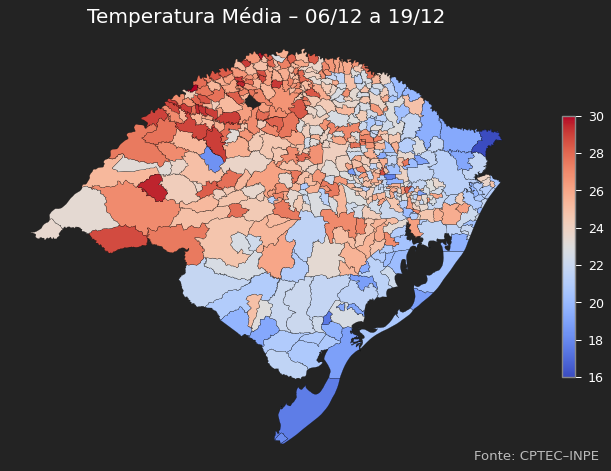

In [9]:
ax = geo_data.plot(column=geo_data.Temperatura,cmap='coolwarm',edgecolor='black')
ax.text(0.9, 0.01, 'Fonte: CPTEC–INPE', transform=ax.transAxes)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mpl.colors.Normalize(vmin=16, vmax=30))
plt.title('Temperatura Média – 06/12 a 19/12')
plt.colorbar(sm,shrink=0.6)
plt.axis('off');

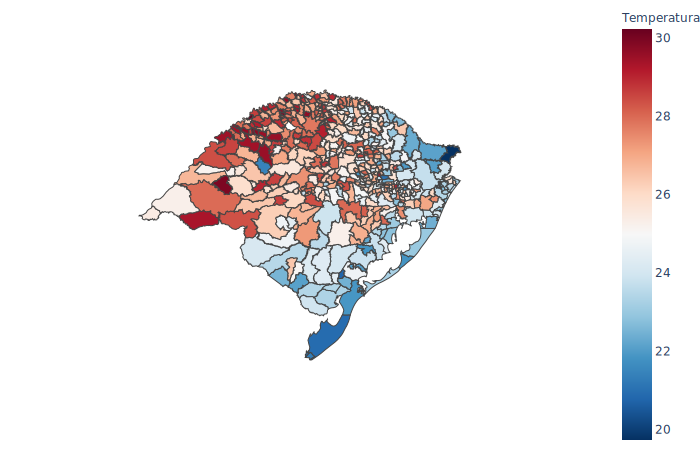

In [17]:
# convert the geo-dataframe to geojson
my_geojson = json.loads(geo_data.to_json())
import plotly.express as px
fig = px.choropleth(geo_data, 
                    color='Temperatura',
                    geojson=my_geojson, 
                    locations=geo_data['Município'], 
                    color_continuous_scale="RdBu_r",
                    featureidkey="properties.Município",
                    hover_data=["Município", "Temperatura"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# fig.show()
fig.show('svg');